# Multivariate time series analysis

This notebook aims at predicting stock price using **mulitvariate time series model**. Here, instead of just using historical price, I will also used other variables such as Open, Close, High, Low price, and transaction Volume. I will convert them to **features usually used by those "technical analysts"** who predicts stock price purely by reading candlestick chart. These features includes:
* Full height of the stick
* Height of the stick body
* Height of the upper and lower part of the stick
* ...

Also, percentage change of these values will be used instead of absolute values. This is to counter non-stationary and un-scaled data.

### Model intuition:

Prediction is made by doing regression on historical values of all variables.

\begin{equation}
x_1(t) = \alpha + \beta_{11} x_1(t-1) + \beta_{12} x_2(t-1) + \beta_{13} x_3(t-1) + ... + \beta_{21}x_1(t-2) + \beta_{22} x_2(t-2) + \beta_{23} x_3(t-2) + ...
\end{equation}

### Results
* Validation results show price moving down, following the trend, and against actual values. This is similar to other model.
* Future prediction results makes the most sense so far: a small increment, with some fluctuation. The trend is similar to SARIMA and Facebook Prophet.

### Conclusions

These features are unlikely to do anygood in future prediction. Thus, I think the results of those "technical analyst" are very doubtful.

## Import libraries and data

In [232]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from scipy import stats
import datetime
import statsmodels as sm
from statsmodels.tsa.api import VAR, VARMAX
from sklearn.preprocessing import StandardScaler


# Library for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import rcParams
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 18

}
rcParams.update(params)
rcParams['figure.figsize'] = 10, 5
rcParams['figure.dpi'] = 100

from mplfinance.original_flavor import candlestick2_ohlc
import mplfinance as mpf

In [258]:
# Stock price
asset = "^GSPC"
df_orig = wb.DataReader('^GSPC', data_source='yahoo', start='2015-1-1')
df_orig.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

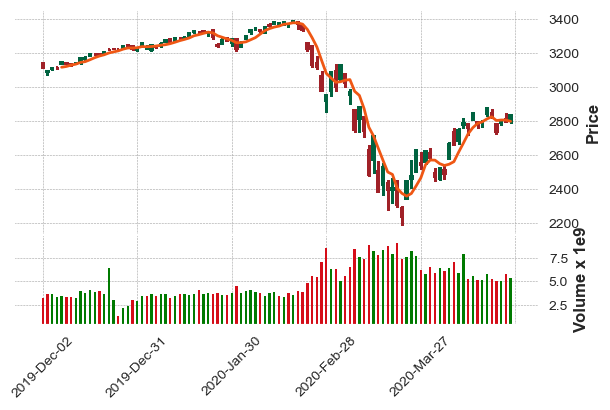

In [259]:
df_plt = df_orig[-100:]
kwargs = dict(type='candle',mav=(5),volume=True,figratio=(10,6),figscale=0.75)
mpf.plot(df_plt,**kwargs,style='charles')

## Data wrangling

In [260]:
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
        adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [261]:
adf_test(df_orig['Adj Close'])

Test Statistic            -1.557865
p-value                    0.504717
# Lags                     9.000000
# Observations          1328.000000
Critical Value (1%)       -3.435284
Critical Value (5%)       -2.863719
Critical Value (10%)      -2.567930
dtype: float64
 Series is Non-Stationary


In [262]:
# Make data stationary
df_differenced = df_orig.diff().dropna()
adf_test(df_differenced['Adj Close'])

Test Statistic         -8.629051e+00
p-value                 5.822572e-14
# Lags                  2.200000e+01
# Observations          1.314000e+03
Critical Value (1%)    -3.435336e+00
Critical Value (5%)    -2.863742e+00
Critical Value (10%)   -2.567942e+00
dtype: float64
 Series is Stationary


# Data processing
## Extract by percentage and differences instead of absolute values

In [263]:
df = df_orig.copy()
df['stick_height'] = (df['High'] - df['Low'])/df['Adj Close']
df['open_gap'] = (df['Open'] - df['Close'].shift(1))/df['Adj Close']
df['upper_stick'] = (df['High']-df[['Open','Close']].max(axis=1))/df['Adj Close']
df['lower_stick'] = (df[['Open','Close']].min(axis=1)-df['Low'])/df['Adj Close']
df['volume_change'] = df['Volume'].diff(1)/df['Volume'].shift(1)
df['price_change'] = df['Adj Close'].diff(1)/df['Adj Close'].shift(1)
df = df[1:]
df['volume_change'] = df['volume_change'].clip(lower=-0.6, upper=0.6)

In [264]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,stick_height,open_gap,upper_stick,lower_stick,volume_change,price_change
Date,,,,,,,,,,,,
2015-01-02,2072.360107,2046.040039,2058.899902,2058.199951,2708700000,2058.199951,0.012788,0.000000,0.006540,0.005908,0.039381,-0.000340
2015-01-05,2054.439941,2017.339966,2054.439941,2020.579956,3799120000,2020.579956,0.018361,-0.001861,0.000000,0.001603,0.402562,-0.018278
2015-01-06,2030.250000,1992.439941,2022.150024,2002.609985,4460110000,2002.609985,0.018880,0.000784,0.004045,0.005078,0.173985,-0.008893
2015-01-07,2029.609985,2005.550049,2005.550049,2025.900024,3805480000,2025.900024,0.011876,0.001451,0.001831,0.000000,-0.146774,0.011630
2015-01-08,2064.080078,2030.609985,2030.609985,2062.139893,3934010000,2062.139893,0.016231,0.002284,0.000941,0.000000,0.033775,0.017888


In [265]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close,stick_height,open_gap,upper_stick,lower_stick,volume_change,price_change
count,1337.000000,1337.000000,1337.000000,1337.000000,1.337000e+03,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,2495.723664,2470.778273,2483.956627,2484.140978,3.727121e+09,2484.140978,0.010140,0.000135,0.001965,0.002618,0.011173,0.000308
std,379.049421,376.750914,377.894711,377.894334,8.764765e+08,377.894334,0.008995,0.005236,0.002736,0.003494,0.159409,0.011685
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956,0.001456,-0.084836,0.000000,0.000000,-0.600000,-0.119841
25%,2113.649902,2097.820068,2106.239990,2107.389893,3.246900e+09,2107.389893,0.004921,-0.001077,0.000374,0.000509,-0.070475,-0.003035
50%,2473.830078,2455.790039,2465.379883,2467.699951,3.549540e+09,2467.699951,0.007416,0.000259,0.001226,0.001712,-0.002753,0.000489
75%,2807.040039,2779.260010,2795.639893,2793.899902,3.943810e+09,2793.899902,0.012065,0.001701,0.002565,0.003515,0.082530,0.004735
max,3393.520020,3378.830078,3380.449951,3386.149902,9.044690e+09,3386.149902,0.080767,0.043737,0.038722,0.049031,0.600000,0.093828


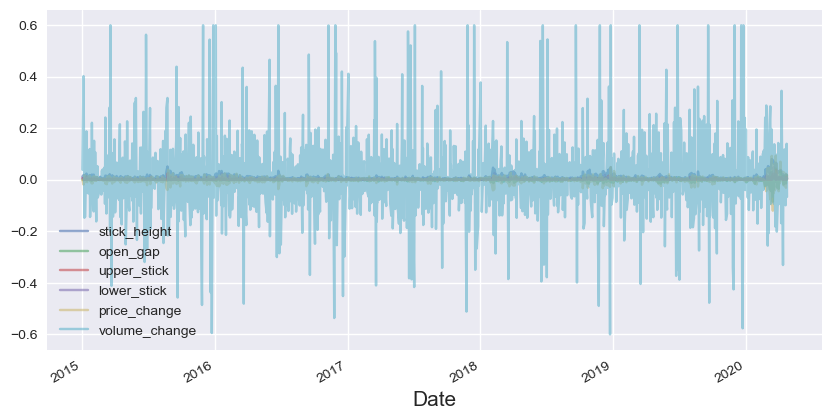

In [266]:
train_cols = ['stick_height','open_gap','upper_stick','lower_stick','price_change','volume_change']
df[train_cols].plot(alpha=0.6)

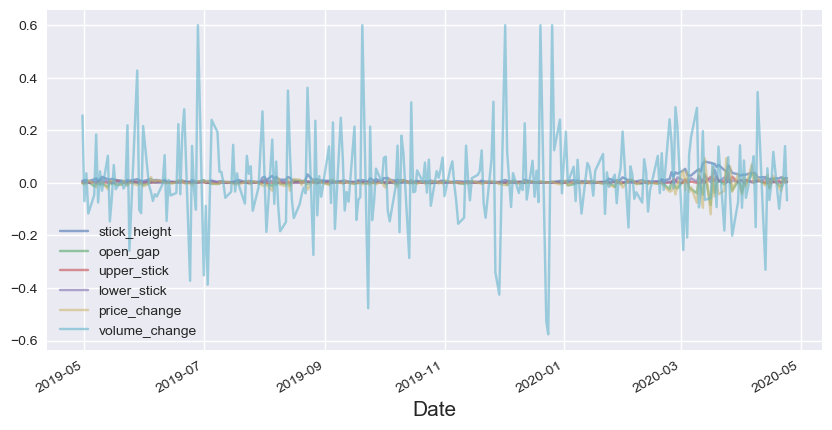

In [267]:
df[-250:][train_cols].plot(alpha=0.6)

In [268]:
adf_test(df['price_change'])

Test Statistic         -1.141984e+01
p-value                 6.916688e-21
# Lags                  8.000000e+00
# Observations          1.328000e+03
Critical Value (1%)    -3.435284e+00
Critical Value (5%)    -2.863719e+00
Critical Value (10%)   -2.567930e+00
dtype: float64
 Series is Stationary


## Train test split

In [269]:
pred_idx = -30
df_train = df.copy()[:pred_idx]
df_val = df.copy()[pred_idx:]

## Build model using VAR and validate

### Build model

In [270]:
model = VAR(df_train[train_cols])
model = model.fit(maxlags=20, ic='aic')
model.summary()

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 26, Apr, 2020
Time:                     00:15:06
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -58.8867
Nobs:                     1297.00    HQIC:                  -59.7978
Log likelihood:           28457.6    FPE:                6.20381e-27
AIC:                     -60.3451    Det(Omega_mle):     4.70868e-27
--------------------------------------------------------------------
Results for equation stick_height
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.002187         0.000365            5.993           0.000
L1.stick_height           0.235523         0.034981            6.733           0.000
L1.open_gap              -0.095111   

### Forecast with validation set

In [271]:
lag_order = model.k_ar
df_for_pred = df_train[-lag_order:]
forecast = model.forecast(df_for_pred[train_cols].values,np.abs(pred_idx))

In [272]:
def plot_time(y_train, y_pred, start_date=None, y_val=None):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    x_train = np.arange(-len(y_train),0,1)
    x_pred = np.arange(1,len(y_pred)+1,1)
    plt.plot(x_train, y_train, color='black', linewidth=1.5, label='Historical price')
    plt.plot(x_pred, y_pred, color='red',label='Prediction',alpha=0.8)
    try:
        x_val = np.arange(1,len(y_val)+1,1)
        plt.plot(x_val, y_val, color='blue',label='Val',alpha=0.6)
    except:
        pass
    plt.xlabel('Days')
    plt.ylabel('Price')
    fig.canvas.draw()
    
    # Label start date
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    if start_date != None:
        for i in range(len(labels)):
            if labels[i] == '0':
                labels[i] = start_date
    ax.set_xticklabels(labels)
    plt.legend(loc='best')

In [273]:
y_train = df_train[-200:]['price_change']
y_change_pred = forecast[:,4]
start_date = df_train.index[-1]
y_val = df_val[:]['price_change']

Text(74.47222222222221, 0.5, 'Price change')

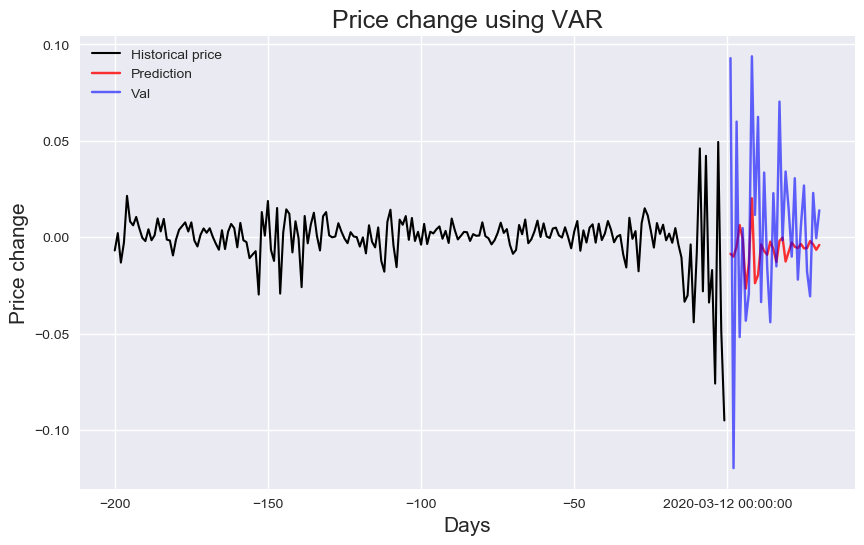

In [274]:
plot_time(y_train, y_change_pred, start_date, y_val)
plt.title("Price change using VAR")
plt.ylabel('Price change')

In [275]:
def make_forward_pred(y_start, change_rate):
    outlist = []
    y_last = y_start
    for rate in change_rate:
        y_cur = y_last*(1+rate)
        outlist.append(y_cur)
        y_last = y_cur
    return outlist

In [276]:
y_pred = make_forward_pred(df_train['Adj Close'].values[-1], y_change_pred)

In [277]:
y_train = df_train[-200:]['Adj Close']
start_date = df_train.index[-1]
y_val = df_val[:]['Adj Close']

Text(0.5, 1, 'Price pred using VAR')

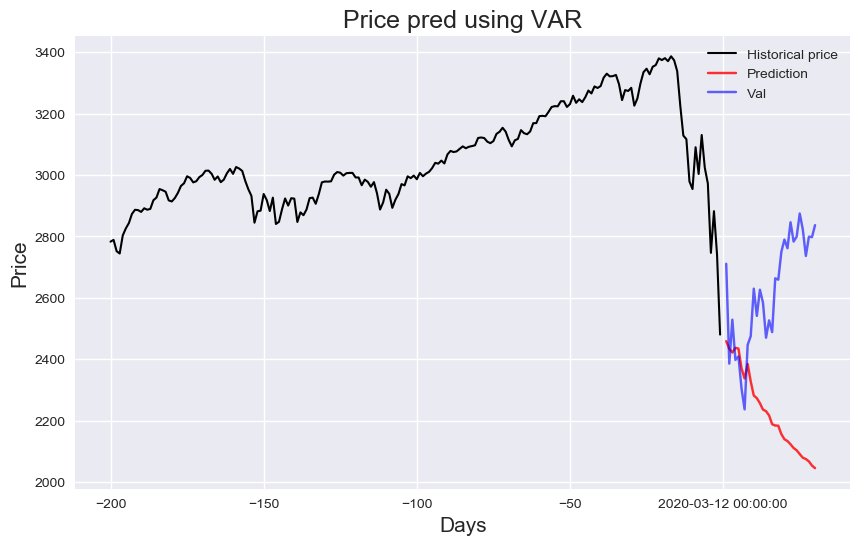

In [278]:
plot_time(y_train, y_pred, start_date, y_val)
plt.title("Price pred using VAR")

## Full prediction

In [279]:
model = VAR(df[train_cols])
model = model.fit(maxlags=20, ic='aic')
model.summary()

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 26, Apr, 2020
Time:                     00:15:14
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -57.1376
Nobs:                     1321.00    HQIC:                  -58.5659
Log likelihood:           28584.0    FPE:                1.56258e-26
AIC:                     -59.4225    Det(Omega_mle):     1.02141e-26
--------------------------------------------------------------------
Results for equation stick_height
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.001766         0.000346            5.103           0.000
L1.stick_height           0.279841         0.034183            8.187           0.000
L1.open_gap              -0.070583   

In [280]:
lag_order = model.k_ar
df_for_pred = df[-lag_order:]
forecast = model.forecast(df_for_pred[train_cols].values,np.abs(pred_idx))

In [281]:
y_change_pred = forecast[:,4]
y_pred = make_forward_pred(df['Adj Close'].values[-1], y_change_pred)

Text(0.5, 1, 'Price pred using VAR')

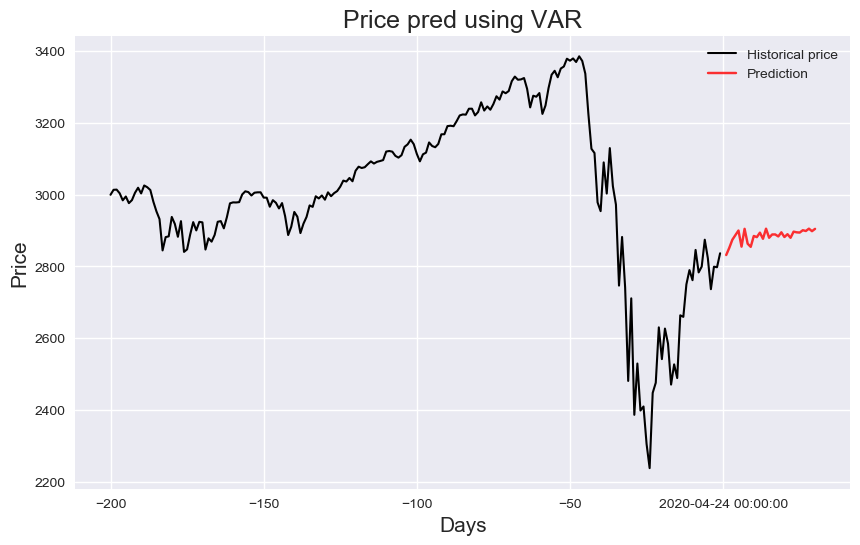

In [282]:
y_train = df[-200:]['Adj Close']
start_date = df.index[-1]
plot_time(y_train, y_pred, start_date)
plt.title("Price pred using VAR")